In [ ]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import seaborn as sns
import scikitplot as skplt
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

np.random.seed(42)
random.seed(42)

In [ ]:
!pip install scikit-plot

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# EDA

In [ ]:
train = pd.read_csv("/kaggle/input/house-price-dls/house_price_train.csv")
train

In [ ]:
len(train.residential_complex.unique())

## Смотрим на данные

In [ ]:
train.info()

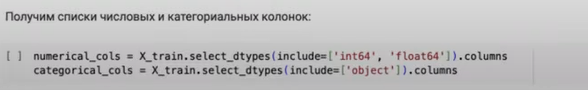

In [ ]:
numerical_cols = train.select_dtypes(include = ['int64', 'float64']).columns
categorical_cols = train.select_dtypes(include = ['object']).columns
categorical_cols

In [ ]:
str_f  = ['author','author_type','location','deal_type','accommodation_type','district','street','underground','residential_complex']

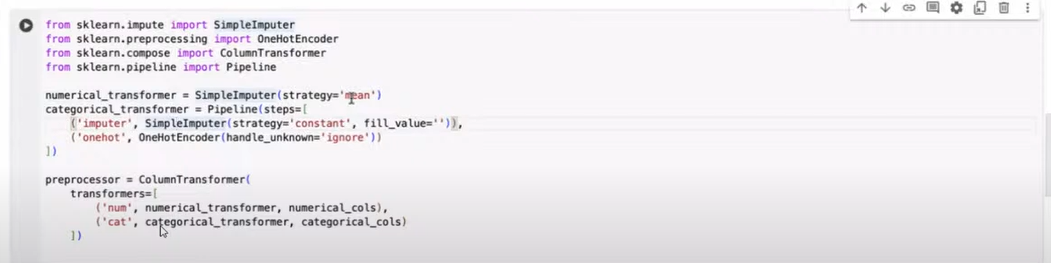

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value= '')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num',numerical_transformer, numerical_cols),
        ('cat',categorical_transformer,categorical_cols)
    ])

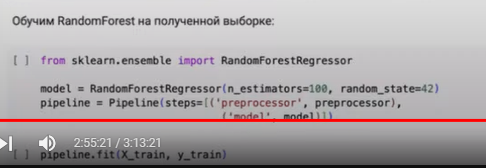

In [ ]:
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', model)
])

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
arr_l = []
for i in range(len(str_f)):
    le = OrdinalEncoder(handle_unknown='use_encoded_value',
                                 unknown_value=-1)
    train[str_f[i]] = le.fit_transform(np.array(train[str_f[i]]).reshape(-1, 1))
    arr_l.append(le)

In [ ]:
corr = train.drop(columns = ['id']).corr() 
plt.figure(figsize=(12, 10))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True, annot_kws={"size": 8}, square=True);

##  Проверка на выбросы и дубликаты

In [ ]:
train.describe()

In [ ]:
len(train)- len(train.drop_duplicates())

## Целевая переменная

In [ ]:
sns.displot(train["price"] , color="skyblue", label="Symdol Length");

In [ ]:
train["price"] = np.log(train["price"])
sns.displot(train["price"] , color="skyblue", label="Symdol Length");

## `NaN`-ы

In [ ]:
train.info()

In [ ]:
train.isna().sum()

In [ ]:
train.isna()

# взглянем на столбцы с `NaN`

In [ ]:
sns.displot(train["district"] , color="skyblue", label="Symdol Length");
sns.displot(train["street"] , color="skyblue", label="Symdol Length");
sns.displot(train["underground"] , color="skyblue", label="Symdol Length");

## Замена `NaN`-ов на `mode`

In [ ]:
train.underground = train.underground.fillna(stats.mode(train.underground)[0][0])

train.district = train.district.fillna(stats.mode(train.district)[0][0])

train.street = train.street.fillna(stats.mode(train.street)[0][0])
train.residential_complex = train.residential_complex.fillna(stats.mode(train.residential_complex)[0][0])
train

In [ ]:
train.info()

In [ ]:
train.columns

## Генерация новых фич(год и месяц)

In [ ]:
train['year'] = int(train['date'][0].split("-")[0])
train['month'] = int(train['date'][0].split("-")[1])
train = train.drop(columns = ["date"])
train

In [ ]:
sns.displot(train["floor"] , color="skyblue", label="Symdol Length");

## Генерация фич

In [ ]:
#train["mean_room_area"] = train["area"]/train["rooms"]

In [ ]:
train

In [ ]:
col = [ 'floor', 'floors_count', 'rooms_count',
       'total_meters']

In [ ]:
col_kw = ['kw1', 'kw2', 'kw3',
       'kw4', 'kw5', 'kw6', 'kw7', 'kw8', 'kw9', 'kw10', 'kw11', 'kw12',
       'kw13']

In [ ]:
train

In [ ]:
for i in col:
    for j in col:
        train[f"feature_{i}*{j}"] = train[i]*train[j]
        if i != j and np.min(train[j]) != 0:
            train[f"feature_{i}/{j}"] = train[i]/train[j]
train

In [ ]:
#for i in col_kw:
#    for j in col_kw:
#        if i != j:
#            train[f"feature_{i}*{j}"] = train[i]*train[j]

In [ ]:
train

In [ ]:
corr = train.corr() 
plt.figure(figsize=(17, 17))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)], cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,annot=True, annot_kws={"size": 8}, square=True);

##  Визуализация данных 

In [ ]:
import plotly.express as px
from sklearn.decomposition import PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scal_data = scaler.fit_transform(train.drop(columns = ["price"]))

n_components = 2
pca = TruncatedSVD(n_components)
pca.fit(scal_data)

pca_data = pca.transform(scal_data)

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'Price'

'''plt.figure(figsize=(10, 5))
plt.scatter(pca_data[:, 0], pca_data[:, 1], color=train.price)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Transformed Data')'''

fig = px.scatter(
    pca_data,
    x=0, y=1,
    color=train.price,
    labels=labels,
    title=f'PCA Transformed Data',
)
fig.show()

## Models

In [ ]:
X = train.drop(columns = ['price'])
y = train['price']
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=42, train_size=0.8, shuffle=True)

In [ ]:
numerical_cols = X_train.select_dtypes(include = ['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include = ['object']).columns
categorical_cols

In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_transformer = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())])
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value= '')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers = [
        ('num',numerical_transformer, numerical_cols),
        ('cat',categorical_transformer,categorical_cols)
    ])

In [ ]:
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.model_selection import KFold, GridSearchCV

In [ ]:
"""kf = KFold(n_splits=5, shuffle=True, random_state=69) # cross validation generator
# KNN
classifier = KNeighborsRegressor()
print(f"Параметры классификатора:\n{classifier.get_params().keys()}")

parameters_grid = {
    'metric': ['l1', 'l2', 'euclidean', 'minkowski'],
    'n_neighbors': np.arange(5, 30)
}

model = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('grid_cv', GridSearchCV(estimator=classifier, param_grid=parameters_grid, scoring='neg_mean_squared_error', cv=kf, n_jobs=-1))
])

model.fit(X_train, y_train)

print(f"grid_cv.best_estimator_: {model['grid_cv'].best_estimator_}")
print(f"grid_cv.best_score_: {model['grid_cv'].best_score_}")

y_true, y_pred = y_test, model.predict(X_test)
print(f"\nRegression report:\n{metrics.mean_squared_error(y_true, y_pred)}")"""

## kNN

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [ ]:
model =  KNeighborsRegressor(n_neighbors = 15)
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

metrics.mean_squared_error(y_test, y_pred, squared=False)

## LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
model = LinearRegression()

pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

metrics.mean_squared_error(y_test, y_pred, squared=False)

## CatBoost

In [ ]:
!pip install catboost

In [ ]:
text_processing = {
                    "tokenizers": [{
                        "tokenizer_id": "Space",
                        "separator_type": "ByDelimiter",
                        "delimiter": " "
                    }],
                    "dictionaries" : [ {
                        "dictionary_id" : "Word",
                        "max_dictionary_size" : "50",
                        "occurrence_lower_bound" : "10",
                        "gram_order" : "1"
                    }],
                    "feature_processing": {
                        "default": [{
                            "dictionaries_names": [ "Word"],
                            "feature_calcers": ["BoW"],
                            "tokenizers_names": ["Space"]
                        }],
                    }
                }


In [ ]:
from catboost import CatBoostRegressor
model = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.05,
    loss_function='RMSE',
    #use_best_model= True,
    task_type='GPU',
    verbose=1000
    #text_processing = text_processing
)
pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', model)
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

metrics.mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
from catboost import CatBoostRegressor
from catboost import Pool

def fit_model(train_pool, validation_pool, **kwargs):
    model = CatBoostRegressor(
        iterations=20000,
        learning_rate=0.05,
        loss_function='RMSE',
        use_best_model= True,
        task_type='GPU',
        text_processing = text_processing
    )

    return model.fit(
        train_pool,
        eval_set=validation_pool,
        verbose=1000,
    )

In [ ]:
train_pool = Pool(
    X_train, y_train,
    text_features = ['author','author_type','location','deal_type','accommodation_type','district','street','underground','residential_complex']
)

validation_pool = Pool(
    X_test, y_test,
    text_features = ['author','author_type','location','deal_type','accommodation_type','district','street','underground','residential_complex']
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

model = fit_model(train_pool, validation_pool)

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(validation_pool)
mean_squared_error(y_test, y_pred, squared=False)

In [ ]:
from sklearn.metrics import mean_squared_error
(60- mean_squared_error(np.exp(y_test), np.exp(y_pred), squared=False))/3.75

In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=True,inplace=True)

    fig = px.bar(
        data_frame = fi_df,
        y = 'feature_names',
        x = 'feature_importance',
        barmode = 'group'
    )
    return fig

In [ ]:
plot_feature_importance(model.feature_importances_,X_train.columns,'CatBoost')

# Predict

In [ ]:
test = pd.read_csv("/kaggle/input/house-price-dls/house_price_test.csv")
test

In [ ]:
y_pred = pipeline.predict(test)
y_pred

In [ ]:
test.info()

In [ ]:
test.underground = test.underground.fillna(stats.mode(train.underground)[0][0])

test.district = test.district.fillna(stats.mode(train.district)[0][0])

test.street = test.street.fillna(stats.mode(train.street)[0][0])
test.residential_complex = test.residential_complex.fillna(stats.mode(train.residential_complex)[0][0])
test

In [ ]:
#for i in range(len(str_f)):
#    test[str_f[i]] = arr_l[i].transform(np.array(test[str_f[i]]).reshape(-1, 1))

In [ ]:
for i in col:
    for j in col:
        test[f"feature_{i}*{j}"] = test[i]*test[j]
        if i != j  and np.min(test[j]) != 0:
            test[f"feature_{i}/{j}"] = test[i]/test[j]

In [ ]:
test

In [ ]:
test_pool = Pool(
    test,
    text_features = ['author','author_type','location','deal_type','accommodation_type','district','street','underground','residential_complex']
)
y_pred = model.predict(test_pool)

In [ ]:
y_pred

In [ ]:
submission = pd.read_csv("/kaggle/input/house-price-dls/house_price_sample_submission.csv")
submission['price'] = np.exp(y_pred)
submission

In [ ]:
submission.to_csv("catboost_pipeline.csv", index = False)

In [ ]:
submission.to_csv("catboost_new_feature_round.csv", index = False)

In [ ]:
submission = pd.read_csv("/kaggle/working/catboost_new_feature.csv")
submission['price'] = np.round(submission['price'],2)
submission